### GradCAM (Gradient class activation mappinng)

这个版本主要用来了解制作Grad_Cam的过程，并没有特意封装

每行代码几乎都有注解

---


CNN卷积一直都是一个神秘的过程

过去一直被以黑盒来形容

能够窥探CNN是一件很有趣的事情， 特别是还能够帮助我们在进行一些任务的时候

了解模型判别目标物的过程是不是出了什么问题

而Grad-CAM就是一个很好的可视化选择

因为能够生成高分辨率的图并叠加在原图上， 让我们在研究一些模型判别错误的时候， 有个更直观的了解

那么具体是如何生成Grad CAM的呢？
老规矩先上图， 说明流程一定要配图

![在这里插入图片描述](https://img-blog.csdnimg.cn/20190806231921909.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NDYzODk1Nw==,size_16,color_FFFFFF,t_70)
借用一下论文作者的图

我们能看到Input的地方就是我们要输入进网络进行判别的
假设这里输入的input 类别是 Tiger cat 

一如往常的进入CNN提取特征

现在看到图中央的Rectified Conv Feature Maps 这个层就是我们要的目标层， 而这个层通常会是整个网路特征提取的最后一层， 为什么呢？ 因为通常越深层的网络越能提取到越关键的特征， 这个是不变的

如果你这边可以理解了就继续往下看呗

我们能看到目标层下面有一排的 $w_1^c w_2^c....$等等的
**这里的w就是权重， 也就是我们需要的目标层512维 每一维对类别Tiger cat的重要程度**
>这里的权重不要理解为前向传播的 每个节点的权重， 两者是不同的

<br>
而这些权重就是能够让模型判别为Tiger cat的最重要的依据
我们要这些权重与目标层的feature map进行linear combination并提取出来
<br>
<br>
那么该怎么求出这些权重呢？

该是上公式的时候了， 公式由论文提出

$L_{Grad-CAM}^c = ReLU(\sum_k\alpha^c_kA^k)$

$\alpha_k^c$ 就是我们上面说的权重

怎么求？摆出论文公式

$\alpha_k^c = \frac{1}{Z} \sum_i \sum_j$ $\frac{\partial y^c}{\partial A^k_{ij}}$

$\frac{1}{Z} \sum_i \sum_j$ 表示进行全局池化，也就是求feature map的平均值

$\frac{\partial y^c}{\partial A^k_{ij}}$ 表示最终类别对我们要的目标层求梯度

所有我们第一步先求出$A^k$ 的梯度之后， 在进行全局池化求得每一个feature map的平均梯度值就会是我们要的$\alpha_k^c$ , 整个池化过程可以是下图红框处
![在这里插入图片描述](https://img-blog.csdnimg.cn/20190809085647532.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NDYzODk1Nw==,size_16,color_FFFFFF,t_70)

这个$\alpha_k^c$ 代表的就是 经过全局池化求出梯度平均值$w_1^c w_2^c....$
也就是我们前面所说的**目标层的512维 每一维对类别Tiger cat的重要程度**

>这边很好理解， 就是把512层feature map分别取平均值， 就取出512个均值， 这512个均值就能分别表示每层的重要程度， 有的值高就显得重要， 有的低就不重要





好的 回到$L_{Grad-CAM}^c = ReLU(\sum_k\alpha^c_kA^k)$

现在$\alpha_k^c$ 我们有了

$A^k$ 表示feature map A 然后深度是k， 如果网络是vgg16， 那么k就是512

把我们求得的$\alpha_k^c$ 与 $A^k$两者进行相乘（这里做的就是线性相乘）， k如果是512， 那么将512张feature map都与权重进行相乘然后加总$\sum_k$

好，最终在经过Relu进行过滤
我们回想一下Relu的作用是什么？

是不是就是让大于0的参数原值输出，小于0的参数就直接等于0 相当于舍弃




<img src="https://img-blog.csdnimg.cn/2019080623401089.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NDYzODk1Nw==,size_16,color_FFFFFF,t_70" width = 400>

其实Relu在这里扮演很重要的角色， 因为我们真正感兴趣的就是哪些能够代表Tiger Cat这个类别的特征， 而那些小于0被舍弃的就是属于其他类别的， 在这里用不上， 所有经过relu的参数能有更好的表达能力

于是 我们就提取出来这个Tiger Cat类别的CAM图啦

那么要注意一下， 这个提取出来的CAM 大小以vgg16来说是14*14像素
因为经过了很多层的卷积

我们要将这个图进行放大到与原输入的尺寸一样大在进行叠加才能展现GradCAM容易分析的优势

当然中间有很多实现的细节包含利用openCV将色彩空间转换


就如下图是我做的一个范例
![](https://img-blog.csdnimg.cn/20190806234652556.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NDYzODk1Nw==,size_16,color_FFFFFF,t_70)
那么是不是就很容易理解网络参数对于黑猩猩面部的权重被激活的比较多，白话的说就是网络是靠猩猩脸部来判别 哦 原来这是黑猩猩啊 ！

当然这样的效果是在预训练网络上(vgg16 imagenet 1000类 包含黑猩猩类）才会有的， 预训练好的参数早就可以轻易的判别黑猩猩了
如果只是单纯的丢到不是预训练的网络会是下面这样子


<img src="https://img-blog.csdnimg.cn/20190806235450213.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NDYzODk1Nw==,size_16,color_FFFFFF,t_70" width=400>


所以网络需要进行训练， 随着训练， 权重会越能突显这个类别的特征
最后透过某些特定的纹路就能进行判别


<br>
<br>
<br>
<br>
<br>
<mark>注意一下，代码中说的目标层就是我们锁定的VGG16中的第29层relu层</mark>



论文连接: https://arxiv.org/pdf/1610.02391v1.pdf

In [2]:
import torch as t
from torchvision import models
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt


In [3]:
class FeatureExtractor():
    """
    1. 提取目标层特征
    2. register 目标层梯度
    """
    def __init__(self, model, target_layers):
        self.model = model
        self.model_features = model.features
        self.target_layers = target_layers
        self.gradients = list()
    def save_gradient(self, grad):
        self.gradients.append(grad)
    def get_gradients(self):
        return self.gradients
    def __call__(self, x):
        target_activations = list()
        self.gradients = list()
        for name, module in self.model_features._modules.items(): #遍历的方式遍历网络的每一层
            x = module(x) #input 会经过遍历的每一层
            if name in self.target_layers: #设个条件，如果到了你指定的层， 则继续
                x.register_hook(self.save_gradient) #利用hook来记录目标层的梯度
                target_activations += [x] #这里只取得目标层的features
        x = x.view(x.size(0), -1) #reshape成 全连接进入分类器
        x = self.model.classifier(x)#进入分类器
        return target_activations, x

        
def preprocess_image(img):
    """
    预处理层
    将图像进行标准化处理
    """
    mean = [0.485, 0.456, 0.406] 
    stds = [0.229, 0.224, 0.225]
    preprocessed_img = img.copy()[:, :, ::-1] # BGR > RGB
    
    #标准化处理， 将bgr三层都处理
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - mean[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
        
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1))) #transpose HWC > CHW
    preprocessed_img = t.from_numpy(preprocessed_img) #totensor
    preprocessed_img.unsqueeze_(0)
    input = t.tensor(preprocessed_img, requires_grad=True)
    
    return input



In [4]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET) #利用色彩空间转换将heatmap凸显
    heatmap = np.float32(heatmap)/255 #归一化
    cam = heatmap + np.float32(img) #将heatmap 叠加到原图
    cam = cam / np.max(cam)
    cv2.imwrite('GradCam_test.jpg', np.uint8(255 * cam))#生成图像
    
    cam = cam[:, :, ::-1] #BGR > RGB
    plt.figure(figsize=(10, 10))
    plt.imshow(np.uint8(255*cam))

In [5]:
class GradCam():
    """
    GradCam主要执行
    1.提取特征（调用FeatureExtractor)
    2.反向传播求目标层梯度
    3.实现目标层的CAM图
    """
    def __init__(self, model, target_layer_names):
        self.model = model
        self.extractor = FeatureExtractor(self.model, target_layer_names)
    def forward(self, input):
        return self.model(input)

    def __call__(self, input):
        features, output = self.extractor(input) #这里的feature 对应的就是目标层的输出， output是图像经过分类网络的输出
        output.data
        one_hot = output.max() #取1000个类中最大的值
            
        self.model.features.zero_grad() #梯度清零
        self.model.classifier.zero_grad() #梯度清零

        one_hot.backward(retain_graph=True) #反向传播之后，为了取得目标层梯度
        
        grad_val = self.extractor.get_gradients()[-1].data.numpy()
        #调用函数get_gradients(),  得到目标层求得的梯
        
        target = features[-1] 
        #features 目前是list 要把里面relu层的输出取出来, 也就是我们要的目标层 shape(1, 512, 14, 14)
        target = target.data.numpy()[0, :] #(1, 512, 14, 14) > (512, 14, 14) 
        
        
        weights = np.mean(grad_val, axis = (2, 3))[0, :] #array shape (512, ) 求出relu梯度的 512层 每层权重
        
        cam = np.zeros(target.shape[1:]) #做一个空白map，待会将值填上 [14,14]
        #(14, 14)  shape(512, 14, 14)tuple  索引[1:] 也就是从14开始开始
        
        #for loop的方式将平均后的权重乘上目标层的每个feature map， 并且加到刚刚生成的空白map上
        for i, w in enumerate(weights): 
            cam += w * target[i, :, :] 
            #w * target[i, :, :]
            #target[i, :, :] = array:shape(14, 14)
            #w = 512个的权重均值 shape(512, )
            #每个均值分别乘上target的feature map
            #在放到空白的14*14上（cam)
            #最终 14*14的空白map 会被填满
            
        cam = cv2.resize(cam, (224, 224)) #将14*14的featuremap 放大回224*224
        cam = cam - np.min(cam)
        cam = cam  / np.max(cam)
        return cam

In [6]:
model=models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [13]:
grad_cam = GradCam(model = models.vgg16(pretrained=True), \
    target_layer_names = ["29"])

#使用预训练vgg16
#我们的目标层取第29层relu, relu层只保留有用的结果， 所以取其层最能突显出特征


E:\ProgramData\Miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


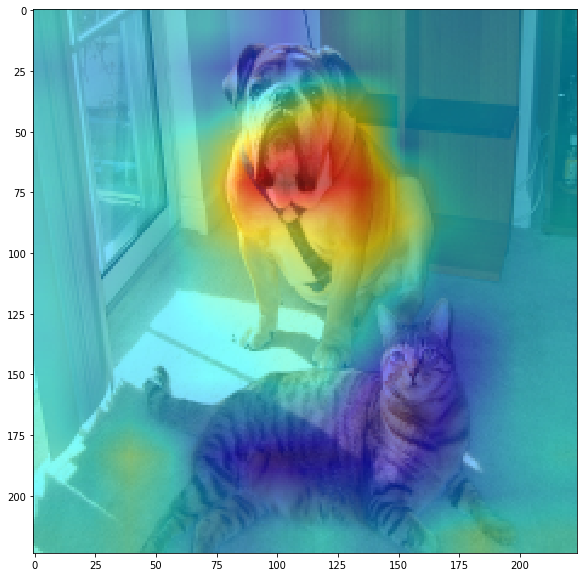

In [14]:

img = cv2.imread('./examples/both.png') #读取图像
img = np.float32(cv2.resize(img, (224, 224))) / 255 #为了丢到vgg16要求的224*224 先进行缩放并且归一化
input = preprocess_image(img)

mask = grad_cam(input)
show_cam_on_image(img, mask)